<a href="https://colab.research.google.com/github/mit1280/Document-AI/blob/main/SAM_DocLayNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install libraries

In [ ]:
!pip install -q transformers datasets seqeval monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


## Import Libraries

In [ ]:
import torch
import datasets
import pandas as pd
import random
from PIL import Image

from datasets import load_dataset, Dataset
from datasets.features import ClassLabel

from PIL import ImageDraw, ImageFont
from huggingface_hub import notebook_login

from transformers import SamProcessor, SamModel
from torch.utils.data import DataLoader

In [ ]:
notebook_login()

## Load dataset

In [ ]:
# Load dataset from huggingface https://huggingface.co/datasets/pierreguillou/DocLayNet-small
# DocLayNet is present in three size: small, base, large
# We will use small as we have only 15 GB RAM in colab
dataset_id ="pierreguillou/DocLayNet-small"

raw_dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(raw_dataset['train'])}")
print(f"Test dataset size: {len(raw_dataset['test'])}")

Train dataset size: 691
Test dataset size: 49


In [ ]:
raw_dataset = raw_dataset.filter(lambda example: len(example['texts']) > 0)

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 688
    })
    validation: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 63
    })
    test: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 49
    })
})

## Pre-process dataset for model fine tuning

In [ ]:
train_df = pd.DataFrame(raw_dataset['train'])
val_df = pd.DataFrame(raw_dataset['validation'])
test_df = pd.DataFrame(raw_dataset['test'])

In [ ]:
train_df['type'] = 'train'
val_df['type'] = 'validation'
test_df['type'] = 'test'
all_df = pd.concat([train_df, val_df, test_df])

In [ ]:
def convert_box(bbox):
    x, y, w, h = tuple(bbox) # Box coordinates are in (left, top, width, height) format
    return [x, y, x+w, y+h] # we need to convert it into (x1, y1, x2, y2) which is (left, top, left+widght, top+height)

In [ ]:
all_df['image'].apply(lambda x: x.size).unique()

array([(1025, 1025)], dtype=object)

In [ ]:
def normalized_box(box, image_width=1025, image_height=1025):
    return [
        int(256 * (box[0] / image_width)),
        int(256 * (box[1] / image_height)),
        int(256 * (box[2] / image_width)),
        int(256 * (box[3] / image_height)),
    ]

In [ ]:
def set_bounding_box(bounding_boxes_block):
    data = ([normalized_box(convert_box(box)) for box in bounding_boxes_block])

    # Convert each inner list to a tuple to make them hashable
    unique_data = list(map(tuple, data))

    # Use set to remove duplicates and convert back to a list of lists
    filtered_bounding_box = list(map(list, set(unique_data)))

    return filtered_bounding_box

In [ ]:
all_df['bboxes_block'] = all_df['bboxes_block'].apply(set_bounding_box)

In [ ]:
all_df['image'] = all_df['image'].apply(lambda x: x.resize((256, 256)))

In [ ]:
all_df['image'].apply(lambda x: x.size).unique()

array([(256, 256)], dtype=object)

In [ ]:
# Find the maximum length of 'bboxes_block'
# max_length = all_df['bboxes_block'].apply(len).max()
# print(max_length)
# # Pad 'bboxes_block' to ensure consistent size
# all_df['bboxes_block'] = all_df['bboxes_block'].apply(lambda x: x + [[0, 0, 0, 0]] * (max_length - len(x)))

In [ ]:
train_dataset = Dataset.from_dict(all_df[all_df['type']=='train'])
val_dataset = Dataset.from_dict(all_df[all_df['type']=='validation'])
test_dataset = Dataset.from_dict(all_df[all_df['type']=='test'])

dataset = datasets.DatasetDict({"train":train_dataset, "test":test_dataset, "validation":val_dataset})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "texts"
boxes_column_name = "bboxes_block"
label_column_name = "categories"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)


In [ ]:
# Define colors for all labels
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(label_list))
font = ImageFont.load_default()
label2color = {label: colors[idx] for idx, label in enumerate(label_list)}

In [ ]:
example = dataset["train"][0]

In [ ]:
bboxs_list = example['bboxes_block']
image = example['image']

In [ ]:
import numpy as np

def create_ground_truth_map(bbox_list, image_shape):
    # Create an empty ground truth map
    ground_truth_map = np.zeros(image_shape, dtype=np.uint8)

    for bbox in bbox_list:
        # Extract bounding box coordinates
        x_min, y_min, x_max, y_max = bbox

        # Ensure coordinates are within image boundaries
        x_min = max(0, x_min)
        y_min = max(0, y_min)

        # Set pixels inside the bounding box to 1
        ground_truth_map[y_min:y_max, x_min:x_max] = 1

    return ground_truth_map

In [ ]:
def get_bounding_box(bboxs):
    x = [bboxs[i][j] for i in range(len(bboxs)) for j in range(0, len(bboxs[i]), 2)]
    y = [bboxs[i][j] for i in range(len(bboxs)) for j in range(1, len(bboxs[i]), 2)]

    x0, y0, x1, y1 = min(x), min(y), max(x), max(y)

    assert x1 >= x0 and y1 >= y0
    bbox = [x0, y0, x1, y1]
    return bbox

In [ ]:
prompts = example['bboxes_block']
ground_truth_mask = create_ground_truth_map(prompts, example['image'].size)
prompt = get_bounding_box(prompts)
prompt

[17, 7, 226, 250]

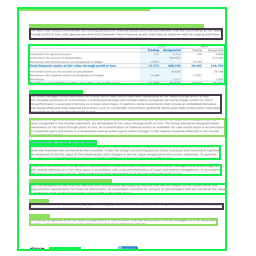

In [ ]:
draw_ = ImageDraw.Draw(image, "RGBA")
example = dataset["train"][0]
categories_list = example['categories']
# We are visulizing boxes on original imag
for categorie, box in zip( categories_list, bboxs_list):
    box = tuple(box) # the row comes in (left, top, width, height) format
    draw_.rectangle(box, outline=label2color[id2label[categorie]], width=2)
    draw_.rectangle(prompt, outline=label2color[id2label[categorie]], width=2)
    # draw_1.text((box[0], box[1]), id2label[categorie], fill=label2color[id2label[categorie]], font=font, size=20)

image

256 256


(-0.5, 255.5, 255.5, -0.5)

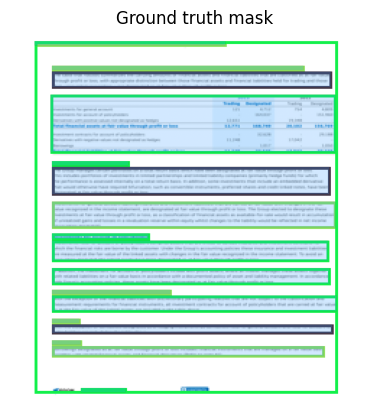

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(2), np.array([0.2])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.2])
    h, w = mask.shape[-2:]
    print(h, w)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = ground_truth_mask
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    # ground_truth_mask = [convert_box(box) for box in item["label"]]
    prompts = item['bboxes_block']

    prompt = get_bounding_box(prompts)
    # prompt = get_bounding_box(ground_truth_mask)
    # prepare image and prompt for the model
    # print(prompt)
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    ground_truth_mask = create_ground_truth_map(prompts, item['image'].size)
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")
model = model.to(device)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
example = dataset["train"][0]

In [ ]:
train_dataset = SAMDataset(dataset=dataset["train"], processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 344/344 [05:47<00:00,  1.01s/it]


EPOCH: 0
Mean loss: 0.39987242295471737


100%|██████████| 344/344 [06:02<00:00,  1.06s/it]


EPOCH: 1
Mean loss: 0.35023734198753226


100%|██████████| 344/344 [06:03<00:00,  1.06s/it]


EPOCH: 2
Mean loss: 0.3269194645244022


100%|██████████| 344/344 [06:03<00:00,  1.06s/it]


EPOCH: 3
Mean loss: 0.31643707978777413


100%|██████████| 344/344 [06:03<00:00,  1.06s/it]


EPOCH: 4
Mean loss: 0.30361042888618484


100%|██████████| 344/344 [06:02<00:00,  1.05s/it]


EPOCH: 5
Mean loss: 0.2913570873179408


100%|██████████| 344/344 [06:01<00:00,  1.05s/it]


EPOCH: 6
Mean loss: 0.283266902110691


100%|██████████| 344/344 [06:01<00:00,  1.05s/it]


EPOCH: 7
Mean loss: 0.2726210335940989


100%|██████████| 344/344 [06:01<00:00,  1.05s/it]


EPOCH: 8
Mean loss: 0.2659807177260518


100%|██████████| 344/344 [06:01<00:00,  1.05s/it]


EPOCH: 9
Mean loss: 0.26354870847751233


100%|██████████| 344/344 [06:02<00:00,  1.05s/it]


EPOCH: 10
Mean loss: 0.26557032807275305


100%|██████████| 344/344 [06:01<00:00,  1.05s/it]


EPOCH: 11
Mean loss: 0.24933351435546958


100%|██████████| 344/344 [06:01<00:00,  1.05s/it]


EPOCH: 12
Mean loss: 0.24481028732085644


  2%|▏         | 7/344 [00:07<05:56,  1.06s/it]


KeyboardInterrupt: ignored

In [ ]:
# If you want to save model locally run below line
# model.save_pretrained("sam-doclayoutNet")
# If you want to save model on Huggingface
model.push_to_hub("sam-fine-tune-doclaynet")

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mit1208/sam-fine-tune-doclaynet/commit/c5bede54474aac349825848a30fa5b5bf242231d', commit_message='Upload model', commit_description='', oid='c5bede54474aac349825848a30fa5b5bf242231d', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
processor.push_to_hub("sam-fine-tune-doclaynet")

CommitInfo(commit_url='https://huggingface.co/Mit1208/sam-fine-tune-doclaynet/commit/935c259445be75c0d9d481afd99a8e4f14cf0982', commit_message='Upload processor', commit_description='', oid='935c259445be75c0d9d481afd99a8e4f14cf0982', pr_url=None, pr_revision=None, pr_num=None)

## Check model masking on Document

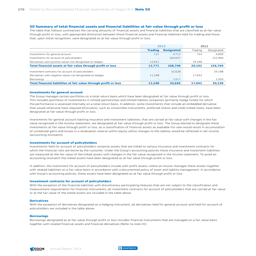

In [ ]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 0

# load image
image = dataset["train"][idx]["image"]
image

In [ ]:
# get box prompt based on ground truth segmentation map

prompts = dataset["train"][idx]['bboxes_block']
ground_truth_mask = create_ground_truth_map(prompts, dataset["train"][idx]['image'].size)
prompt = get_bounding_box(prompts)

# prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [ ]:
model = model.to(device)

In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

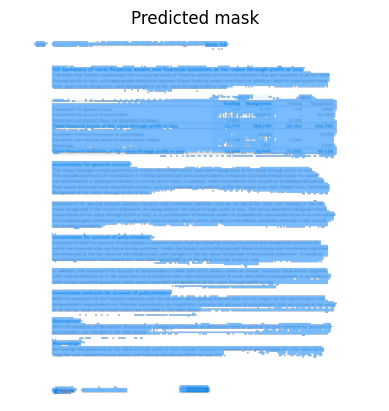

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

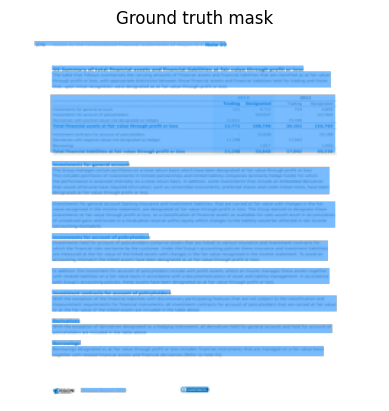

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

### Create bounding box from masks

In [ ]:
import numpy as np
from scipy import ndimage
def find_bboxes_from_ground_truth_map(ground_truth_map):
    # Find connected components in the binary image
    labeled_map, num_labels = ndimage.label(ground_truth_map)

    # Initialize an empty list to store bounding boxes
    bbox_list = []

    for label in range(1, num_labels + 1):
        # Find indices of the current connected component
        indices = np.where(labeled_map == label)

        # Calculate bounding box coordinates for the current component
        y_min = np.min(indices[0])
        y_max = np.max(indices[0])
        x_min = np.min(indices[1])
        x_max = np.max(indices[1])

        bbox = (x_min, y_min, x_max, y_max)
        bbox_list.append(bbox)

    return bbox_list


In [ ]:
found_bboxes = find_bboxes_from_ground_truth_map(medsam_seg)

In [ ]:
main_boxs = [i for i in found_bboxes if i[0]!=i[2] and i[1]!=i[3]]

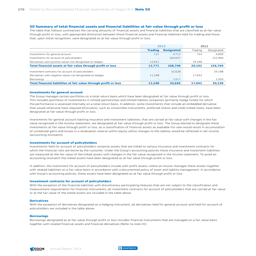

In [ ]:
image2 = dataset["train"][0]["image"]
image2

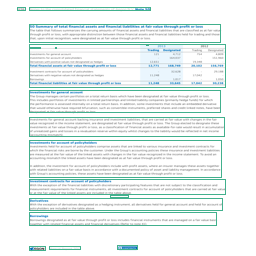

In [ ]:
draw_ = ImageDraw.Draw(image2, "RGBA")
# We are visulizing boxes on original imag
for  box in main_boxs:
    draw_.rectangle(box, outline=label2color[id2label[categorie]], width=1)

image2

## Reference

1. https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb
2. https://github.com/facebookresearch/segment-anything